# Key Insights

In [1]:
import pandas as pd
import yaml

results = pd.read_csv(open("results/benchmark_results.csv"))
meta = yaml.safe_load(open("results/metadata.yaml"))

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]

## How good is each solver and for what cases?

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from humanize import naturaldelta
from matplotlib.patches import Patch

In [3]:
max_num_solvers = 5  # TODO

# Color map
color_map = {
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#7C3AED",  # purple
    "gurobi": "#F66C49",  # red
    "highs": "#43BF94",  # green
    "scip": "#3B82F6",  # blue
}  # TODO change these colors on the website too!


def build_summary(results, meta):
    df = results.copy()

    # -------- classification --------
    def classify_row(r):
        bench = r["Benchmark"]
        size = r["Size"]
        try:
            entry = meta["benchmarks"][bench]
            size_entry = next(x for x in entry["Sizes"] if x["Name"] == size)
        except Exception:
            return "Other", None

        realistic = bool(size_entry.get("Realistic", False))
        ncons = size_entry.get("Num. constraints", None)
        letter = size_entry.get("Size", None)
        problem_class = entry.get("Problem class", "Unknown")

        if letter == "S" or (ncons is not None and ncons < 100_000):
            base = "Small"
        elif letter == "M":
            base = "Medium & realistic" if realistic else "Medium"
        elif letter == "L":
            base = "Large & realistic" if realistic else "Large"
        else:
            base = "Other"

        return base, problem_class

    df[["Benchmark", "Problem_class"]] = df.apply(lambda r: pd.Series(classify_row(r)), axis=1)
    df = df[df["Benchmark"] != "Other"]

    df["Runtime_clean"] = df.apply(
        lambda r: r["Runtime (s)"] if r["Status"] == "ok" else float("nan"), axis=1
    )

    summary = (
        df.groupby(["Benchmark", "Problem_class", "Solver"])
        .agg(
            Runtime_s=("Runtime_clean", "mean"),
            Timeout=("Timeout", "max"),
            Num_problems=("Status", "count"),
            Solved_frac=("Status", lambda s: (s == "ok").mean()),
        )
        .reset_index()
    )

    summary["Slowdown"] = summary.groupby("Benchmark")["Runtime_s"].transform(
        lambda s: s / s.min()
    )
    return summary


# --- Plotting function ---
def plot_runtime_slowdowns(df, figsize=(12, 6)):
    d = df.copy()

    sorted_groups = (
        d.groupby("Benchmark")["Runtime_s"]
        .min()
        .sort_values()
        .reset_index()
    )

    width = 1 / (max_num_solvers + 1)
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    ax.axhline(1, color="grey", linestyle="--")

    for i, row in sorted_groups.iterrows():
        grp = row["Benchmark"]
        subset = d[(d["Benchmark"] == grp) & d["Runtime_s"].notna()].sort_values("Slowdown")
        if subset.empty:
            continue
        xs = i + (np.arange(len(subset)) * width) - 0.5 + width
        ax.bar(xs, subset["Slowdown"], width, color=[color_map[s] for s in subset["Solver"]])
        for j, xval in enumerate(xs):
            y = subset.iloc[j]["Slowdown"] + 0.3
            ax.text(xval, y, f"{subset.iloc[j]['Slowdown']:.1f}x", ha="center", fontsize=9)

    labels = []
    for _, row in sorted_groups.iterrows():
        grp = row["Benchmark"]
        fastest = d[d["Benchmark"] == grp]["Runtime_s"].min()
        timeout = d[d["Benchmark"] == grp]["Timeout"].max()
        num = int(d[d["Benchmark"] == grp]["Num_problems"].max())
        timeout_str = (f"{int(timeout/3600)} hr timeout" if timeout >= 3600 else f"{timeout:.0f} s timeout")
        labels.append(f"{grp} ({num} problems; {timeout_str})\nFastest: {int(fastest)} s")
    ax.set_xticks(np.arange(len(sorted_groups)), labels)

    if "Problem_class" in d.columns:
        first_bench = sorted_groups["Benchmark"].iloc[0]
        class_type = d[d["Benchmark"] == first_bench]["Problem_class"].iloc[0]
        title = f"Solver Runtime Comparison – {class_type}"
    else:
        title = "Solver Runtime Comparison"
    ax.set_title(title)

    ax.set_ylabel("Relative Runtime (normalized)")
    ax.legend(handles=[Patch(color=c, label=s) for s, c in color_map.items()])



# TODO for overall plot -- num solved inside bar?
# TODO make non-ok bars more transparent?

In [4]:
def filter_lp(results, meta):
    return results[
        results["Benchmark"].apply(lambda b: meta["benchmarks"][b]["Problem class"] == "LP")
    ]

def filter_milp(results, meta):
    return results[
        results["Benchmark"].apply(lambda b: meta["benchmarks"][b]["Problem class"] == "MILP")
    ]

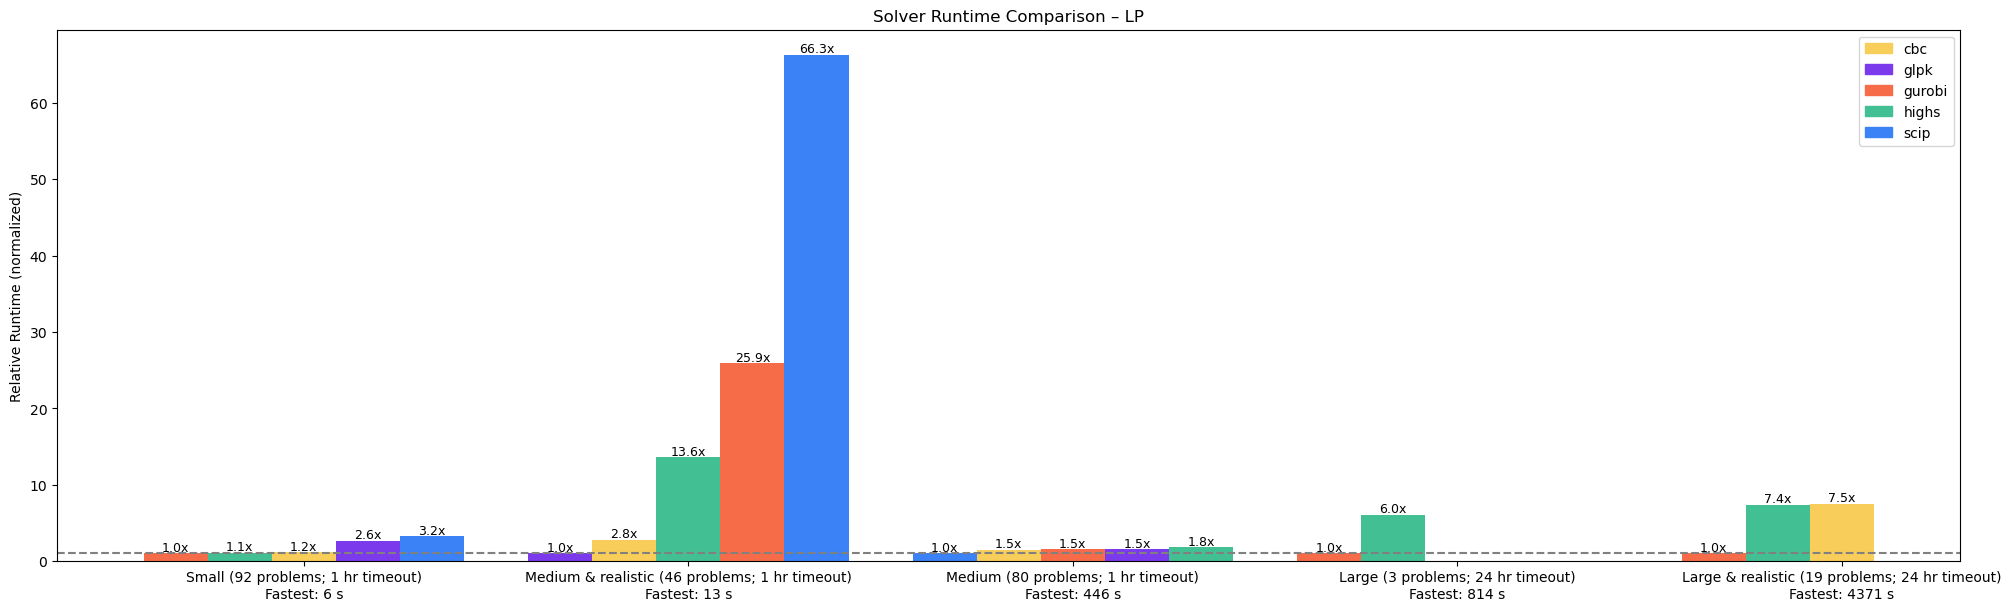

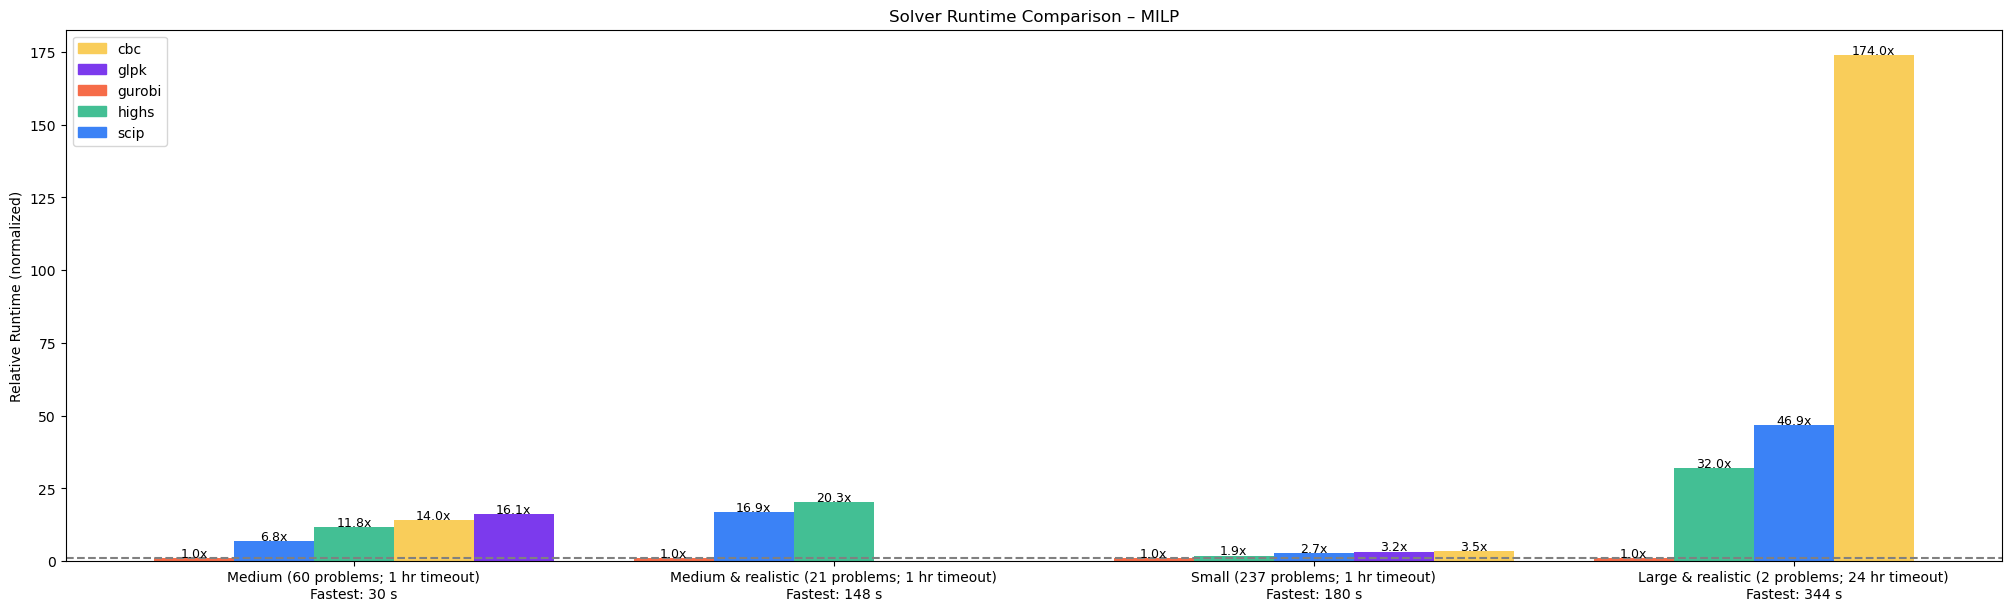

In [23]:
results = pd.read_csv("results/benchmark_results.csv")
meta = yaml.safe_load(open("results/metadata.yaml"))

results_lp   = filter_lp(results, meta)
results_milp = filter_milp(results, meta)

summary_lp = build_summary(results_lp, meta)
plot_runtime_slowdowns(summary_lp, figsize=(20, 6))

summary_milp = build_summary(results_milp, meta)
plot_runtime_slowdowns(summary_milp, figsize=(20, 6))

In [6]:
#from io import StringIO
#
## SGM results
#data = """Benchmark,Solver,Runtime (s),Status,Timeout
#Small (18 problems; 1 hr timeout),gurobi,16.1,ok
#Small (18 problems; 1 hr timeout),highs,94.61,ok
#Small (18 problems; 1 hr timeout),scip,68.89,ok
#Small (18 problems; 1 hr timeout),cbc,349.43,ok
#Small (18 problems; 1 hr timeout),glpk,963.3,ok
#Medium (87 problems; 1 hr timeout),gurobi,125.25,ok
#Medium (87 problems; 1 hr timeout),highs,560.11,ok
#Medium (87 problems; 1 hr timeout),scip,659.39,ok
#Medium (87 problems; 1 hr timeout),cbc,899.76,ok
#Medium (87 problems; 1 hr timeout),glpk,1761.3,ok
#Medium & realistic (19 problems; 1 hr timeout),gurobi,54.86,ok
#Medium & realistic (19 problems; 1 hr timeout),highs,220.96,ok
#Medium & realistic (19 problems; 1 hr timeout),scip,267.89,ok
#Medium & realistic (19 problems; 1 hr timeout),cbc,1445.51,ok
#Medium & realistic (19 problems; 1 hr timeout),glpk,3189.2,ok
#Large (15 problems; 10 hr timeout),gurobi,1124.64,ok
#Large (15 problems; 10 hr timeout),highs,25793.13,ok
#Large (15 problems; 10 hr timeout),scip,31847.48,ok
#Large (15 problems; 10 hr timeout),cbc,35747.02,ok
#Large & realistic (13 problems; 10 hr timeout),gurobi,1235.35,ok
#Large & realistic (13 problems; 10 hr timeout),highs,28762.75,ok
#Large & realistic (13 problems; 10 hr timeout),scip,31252.59,ok
#Large & realistic (13 problems; 10 hr timeout),cbc,35708.26,ok
#"""
#df = pd.read_csv(StringIO(data))
#
## TODO add num solved as fraction
#
#plot_runtime_slowdowns(df, figsize=(18, 6))

### Canonical / representative / featured problems

In [7]:
def build_summary_per_benchmark(results):
    df = results.copy()
    df["Benchmark"] = df["bench-size"]

    # Replace non-ok or NaN with timeout
    df["Runtime_clean"] = df.apply(
        lambda r: r["Runtime (s)"] if r["Status"] == "ok" else r["Timeout"],
        axis=1
    )
    df.loc[df["Runtime_clean"].isna(), "Runtime_clean"] = df["Timeout"]

    summary = (
        df.groupby(["Benchmark", "Solver"])
        .agg(
            Runtime_s=("Runtime_clean", "mean"),
            Timeout=("Timeout", "max"),
            Num_problems=("Status", "count"),
            Solved_frac=("Status", lambda s: (s == "ok").mean())
        )
        .reset_index()
    )

    summary["Slowdown"] = summary.groupby("Benchmark")["Runtime_s"].transform(
        lambda s: s / s.min()
    )

    return summary


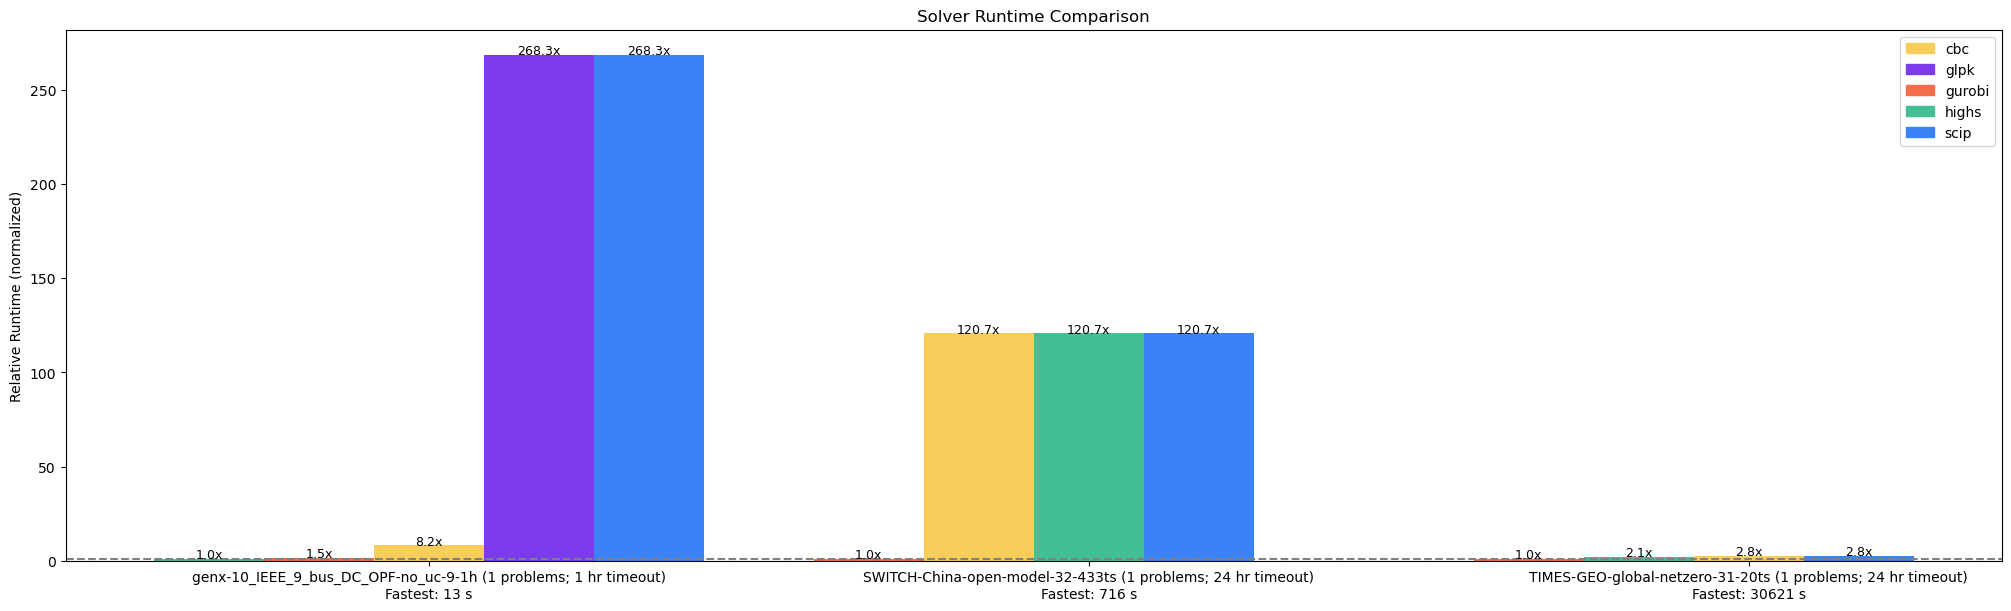

In [8]:
#to_plot = {
#    "pypsa-eur-elec-op-10-3h",
#    "pypsa-eur-sec-5-12h",
#    "genx-10_IEEE_9_bus_DC_OPF-9-1h",
#    "genx-elec_trex_uc-15-24h",
#    "tulipa-1_EU_investment_simple-28-1h",
#    "temoa-US_9R_TS_SP-9-12",
#    "TIMES-GEO-global-netzero-31-20ts",
#}

# New list of representative problems
to_plot = {
    "pypsa-eur-elec-50-1h",
    "pypsa-eur-sec-50-1h",
    "genx-10_IEEE_9_bus_DC_OPF-no_uc-9-1h",
    "SWITCH-China-open-model-32-433ts",
    "ethos_fine_europe_60tp-175-720ts",
    "TIMES-GEO-global-netzero-31-20ts",
    "temoa-US_9R_TS_SP-9_12ts",
}


to_plot_results = results[results["bench-size"].isin(to_plot)]

# keep only latest solver version per solver per benchmark
to_plot_results = (
    to_plot_results
    .sort_values(["bench-size", "Solver", "Solver Release Year"])
    .drop_duplicates(["bench-size", "Solver"], keep="last")
)

# build aggregated summary
summary_subset = build_summary_per_benchmark(to_plot_results)

# plot
plot_runtime_slowdowns(summary_subset, figsize=(20, 6))


In [9]:
#times_problems = [
#    "times-etimeseu-france-elec+heat-co2-multi_stage",
#    "TIMES-GEO-global-netzero",
#    "times-etimeseu-france-elec+heat-multi_stage",
#    "times-etimeseu-france-elec+heat-co2-single_stage",
#    "times-ireland-noco2",
#    "times-etimeseu-europe-elec+heat-multi_stage",
#    "times-etimeseu-europe-elec+heat-co2-multi_stage",
#    "times-etimeseu-europe-elec+heat-co2-single_stage",
#    "TIMES-GEO-global-base",
#    "times-nz-tui",
#    "times-etimeseu-france-elec+heat-single_stage",
#    "times-ireland-noco2-counties",
#    "times-etimeseu-europe-elec+heat-single_stage",
#    "times-nz-kea",
#]
#times_to_plot = {
#    "TIMES-GEO-global-netzero",
#    "times-etimeseu-europe-elec+heat-co2-multi_stage",
#    "times-nz-kea",
#    "times-ireland-noco2-counties",
#    "temoa-US_9R_TS_NZ",
#}
#times_results = results[results["Benchmark"].isin(times_to_plot)]
#
## Fix size names
#times_results.loc[
#    times_results.query('`bench-size` == "times-ireland-noco2-counties-26-1h"').index,
#    "bench-size",
#] = "times-ireland-noco2-counties-26-1ts"
#times_results.loc[
#    times_results.query('`bench-size` == "times-nz-kea-2-24h"').index, "bench-size"
#] = "times-nz-kea-2-24ts"
#
## Remove old solver versions
#times_results = times_results.sort_values(
#    ["bench-size", "Solver", "Solver Release Year"]
#).drop_duplicates(["bench-size", "Solver"], keep="last")
#
#plot_runtime_slowdowns(times_results, figsize=(20, 6))

## What's feasible for open source solvers?

In [10]:
# drop-in replacement so existing code does NOT break
def _humanize_delta(sec: float) -> str:
    """
    Very small replacement for humanize.naturaldelta.
    Converts seconds → s / min / h while keeping same API.
    """
    try:
        sec = float(sec)
    except:
        return "n/a"

    if sec < 60:
        return f"{sec:.0f} seconds"
    elif sec < 3600:
        m = sec / 60
        return f"{m:.1f} minutes"
    else:
        h = sec / 3600
        return f"{h:.1f} hours"

# create fake namespace like the real humanize module
class _FakeHumanize:
    naturaldelta = staticmethod(_humanize_delta)

# now every old line `humanize.naturaldelta()` works normally
humanize = _FakeHumanize()


In [11]:
#import humanize

# Make a table of metadata
meta_data = []
for n, b in meta["benchmarks"].items():
    for s in b["Sizes"]:
        bench_size = n + "-" + s["Name"]
        meta_data.append(
            (
                bench_size,
                b["Problem class"],
                b["Modelling framework"],
                s["Num. variables"],
                s["Num. constraints"],
                s["Spatial resolution"],
                s["Temporal resolution"],
            )
        )
metadata_df = pd.DataFrame(
    meta_data,
    columns=[
        "bench-size",
        "Problem Class",
        "Modelling Framework",
        "Num. Variables",
        "Num. Constraints",
        "Spatial Resolution",
        "Temporal Resolution",
    ],
)

# Merge to get a table with bench-size, fastest os solver, runtime, num vars, num constraints, temp/spatial resolutions
results_n_meta = results.join(metadata_df.set_index("bench-size"), on="bench-size")
results_n_meta["Runtime"] = results_n_meta["Runtime (s)"].apply(humanize.naturaldelta)

# First get the fastest OS solver for each bench-size
os_feasible_results = (
    results_n_meta.query("Solver != 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

# The fastest Gurobi solver for each bench-size
gurobi_results = (
    results_n_meta.query("Solver == 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

cols_of_interest = [
    "Benchmark",
    "Size",
    "Num. Variables",
    "Num. Constraints",
    "Spatial Resolution",
    "Temporal Resolution",
    "Solver",
    "Solver Version",
    "Runtime",
]

In [12]:
# collapse Gurobi runtimes per benchmark
gurobi_best = (
    results
    .query('Solver == "gurobi"')
    .sort_values(["bench-size", "Solver Release Year"], ascending=[True, False])
    .drop_duplicates(["bench-size"])
    [["bench-size", "Runtime (s)"]]
    .rename(columns={"Runtime (s)": "Runtime (s) - Gurobi"})
    .set_index("bench-size")
)

# join WITHOUT duplicating rows (safe)
os_feasible_results = os_feasible_results.join(
    gurobi_best,
    on="bench-size",
    how="left",
    rsuffix="_dup"       # avoid column overlap failure
)

# humanized formatted runtime
os_feasible_results["Runtime - Gurobi"] = (
    os_feasible_results["Runtime (s) - Gurobi"]
    .apply(humanize.naturaldelta)
)

cols_of_interest.append("Runtime - Gurobi")


In [13]:
# The largest LP problems solveable by open solvers + largest by Gurobi
largest_lp_results = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_lp_gurobi = (
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_lp_results = pd.concat([largest_lp_gurobi, largest_lp_results])

largest_lp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
72,genx-elec_co2,15-168h,13777201.0,11832633.0,15 nodes,168 hours,gurobi,13.0.0,1.5 hours,NaN
1,TIMES-GEO-global-netzero,31-20ts,5422595.0,5063755.0,31 regions,20 time slices,highs,1.12.0,17.5 hours,8.5 hours
57,temoa-US_9R_TS_NDC,9-12ts,1801794.0,1594091.0,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,10.6 hours,3.7 minutes
33,temoa-US_9R_TS_NZ,9-12ts,1801794.0,1594085.0,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,8.5 hours,3.8 minutes
85,temoa-US_9R_TS_SP,9-12ts,1801794.0,1594116.0,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,4.8 hours,3.8 minutes


In [21]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(22, 6)):
    # filter benchmark subset
    to_plot_results = results[results["bench-size"].isin(to_plot)].copy()

    # keep only newest solver version
    to_plot_results = (
        to_plot_results
        .sort_values(["bench-size", "Solver", "Solver Release Year"])
        .drop_duplicates(["bench-size", "Solver"], keep="last")
    )

    # summarise (adds Runtime_s, Slowdown, Timeout, Num_problems, etc.)
    summary = build_summary_per_benchmark(to_plot_results)

    # now plotting works
    plot_runtime_slowdowns(summary, figsize=figsize)


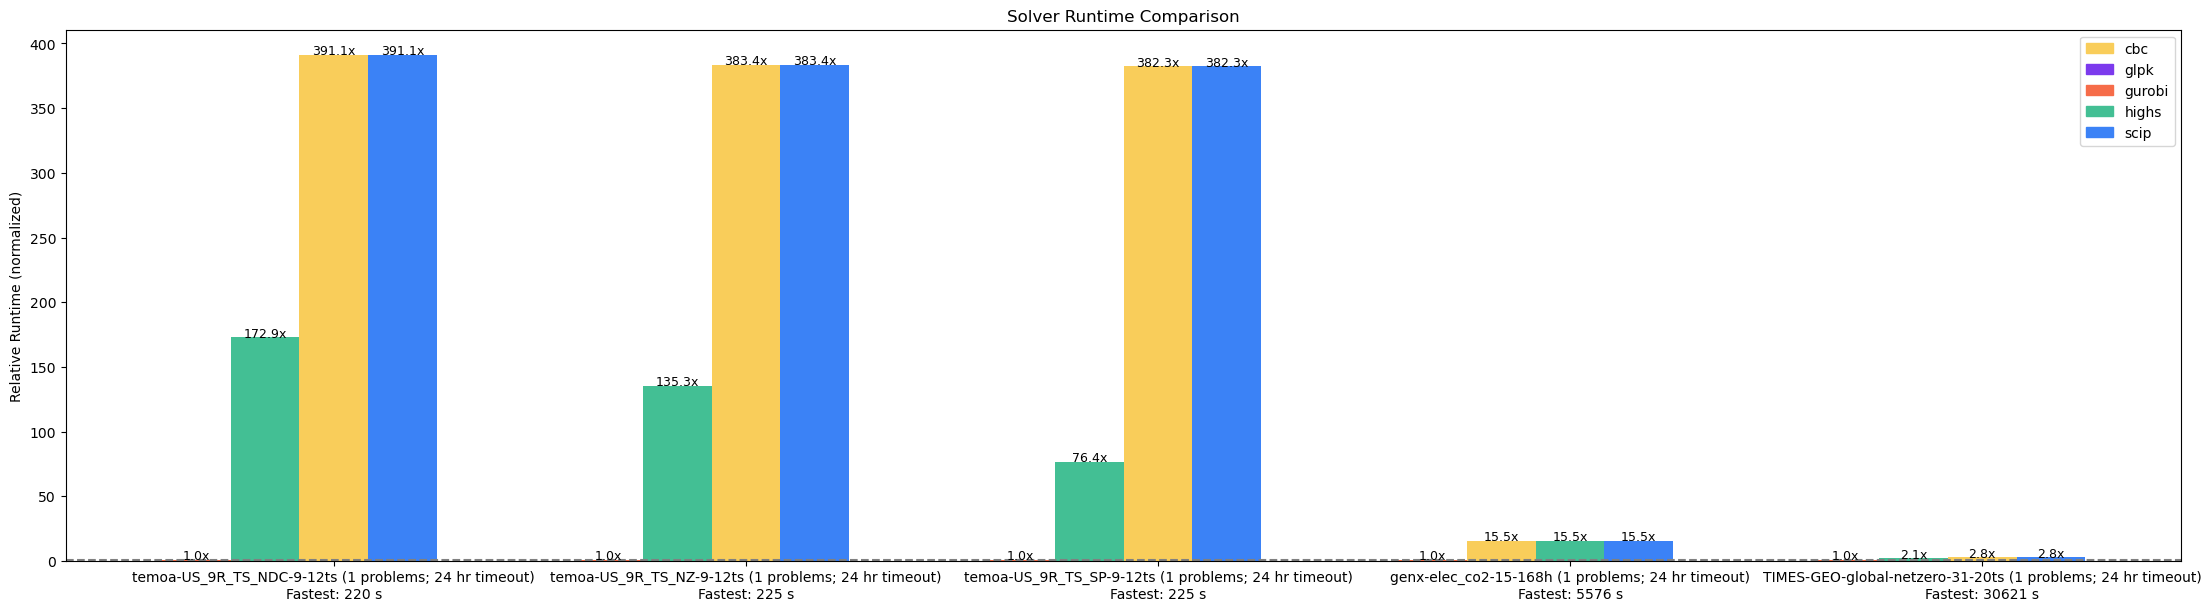

In [22]:
plot_runtime_slowdowns_of(results, set(largest_lp_results["bench-size"]))

In [24]:
# The largest MILP problems solveable by open solvers + largest by Gurobi
largest_milp_results = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_milp_gurobi = (
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_milp_results = pd.concat([largest_milp_gurobi, largest_milp_results])

largest_milp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
40,genx-elec_trex_uc,15-24h,2551346.0,3123898.0,15 nodes,24h hours,gurobi,13.0.0,8.7 minutes,NaN
53,tulipa-1_EU_investment_simple,28-1h,1619451.0,2429440.0,28 nodes,1 hour,highs,1.12.0,3.1 hours,2.8 minutes
727,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483.0,1235166.0,9 nodes,1 hour,scip,8.1.0,39.8 minutes,42 seconds
957,tulipa-1_EU_investment_simple,28-4.3h,372935.0,559104.0,28 nodes,4.3 hours,scip,8.1.0,2.9 minutes,36 seconds
1534,genx-2_three_zones_w_electrolyzer,3-1h,177437.0,232867.0,3 nodes,1 hour,scip,10.0.0,14.3 minutes,3.0 minutes


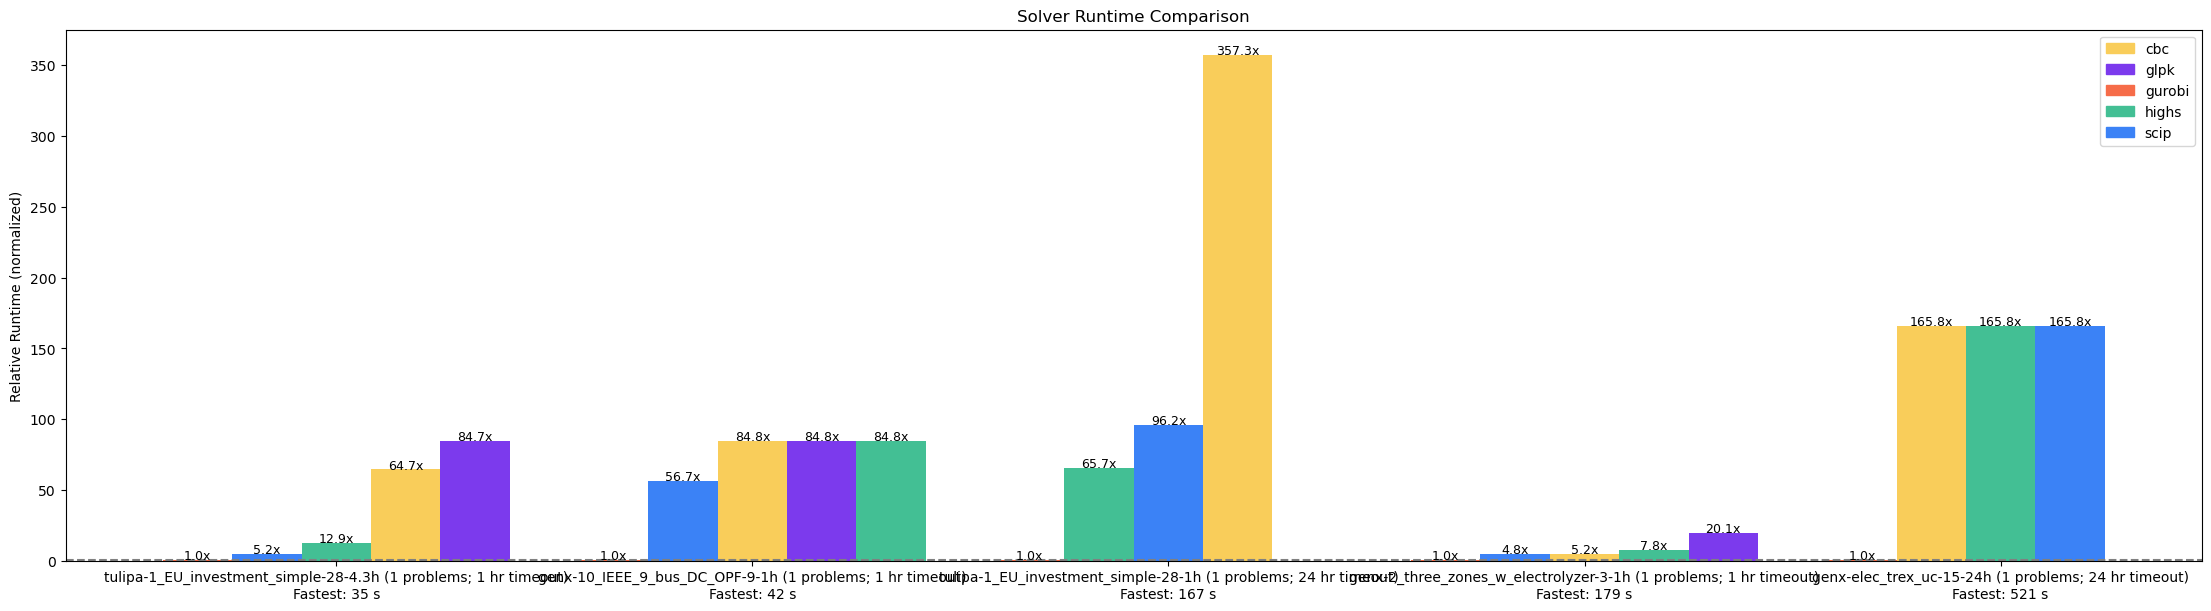

In [25]:
plot_runtime_slowdowns_of(results, set(largest_milp_results["bench-size"]))

In [26]:
# The largest LP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest LPs solveable by open solvers
largest_lp_per_model = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest LP problems solveable by Gurobi
largest_lp_per_model = largest_lp_per_model.join(
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest LP problems available
largest_lp_per_model = largest_lp_per_model.join(
    results_n_meta.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_lp_per_model = largest_lp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_lp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
TIMES,TIMES-GEO-global-netzero,31-20ts,5422595.0,5063755.0,31 regions,20 time slices,highs,1.12.0,17.5 hours,6449851.0,6449851.0
TEMOA,temoa-US_9R_TS_NDC,9-12ts,1801794.0,1594091.0,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,10.6 hours,1801794.0,1801794.0
PyPSA,pypsa-de-elec-trex_vopt,10-3h,703869.0,1501105.0,10 nodes,3 hours,highs,1.12.0,49.2 minutes,8638003.0,52371864.0
ethos.fine,ethos-fine-energyland-full-timeseries,1-8760ts,473179.0,543229.0,1 node,8760 time slices,cbc,2.10.11,40.5 minutes,32770.0,473179.0
GenX,genx-8_three_zones_w_colocated_VRE_storage_ele...,3-1h,257129.0,302449.0,3 nodes,168 hour,cbc,2.10.12,48.9 minutes,13777201.0,13777201.0
OEMOF,OEMOF-simple-dispatch,1-8760ts,140160.0,96360.0,Single-node system with electricity and heat c...,8760 time slices,highs,1.5.0.dev0,1 seconds,140160.0,140160.0
DCOPF,DCOPF-Carolinas_1W,997-1h,122017.0,199255.0,997 nodes,1 hour,highs,1.6.0.dev0,11 seconds,122017.0,122017.0
ZEN-garden,zen-garden-eur-PI,28-2ts,91744.0,126822.0,28 nodes,2 time slices,cbc,2.10.11,3 seconds,3105360.0,3105360.0
FINE,FINE-energyland,1-8760ts,32770.0,40198.0,1 node,8760 time slices,highs,1.9.0,27 seconds,32770.0,32770.0


In [27]:
# The largest MILP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest MILPs solveable by open solvers
largest_milp_per_model = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest MILP problems solveable by Gurobi
largest_milp_per_model = largest_milp_per_model.join(
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest MILP problems available
largest_milp_per_model = largest_milp_per_model.join(
    results_n_meta.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_milp_per_model = largest_milp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_milp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
Tulipa,tulipa-1_EU_investment_simple,28-1h,1619451.0,2429440.0,28 nodes,1 hour,highs,1.12.0,3.1 hours,1619451.0,1619451.0
GenX,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483.0,1235166.0,9 nodes,1 hour,scip,8.1.0,39.8 minutes,2551346.0,2551346.0
DCOPF,DCOPF-Carolinas_uc_6M,997-1h,131278.0,220143.0,997 nodes,1 hour,scip,8.1.0,50.2 minutes,131278.0,131278.0
PyPSA,pypsa-power+ely+battery-ucgas-mod,1-1h,113889.0,219009.0,1 node,1 hour,highs,1.12.0,1.9 minutes,113889.0,113889.0
OEMOF,OEMOF-economic-results,1-8760ts,61326.0,52567.0,Single-node system,8760 time slices,highs,1.6.0.dev0,1 seconds,61326.0,61326.0
ethos.fine,ethos-fine-multi-regional-7tp-12seg,8-84ts,33215.0,64214.0,8 nodes,84 time slices,highs,1.12.0,20.2 minutes,55979.0,55979.0
Sienna,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,73-1h,29520.0,24192.0,73 nodes,48 hours,highs,1.12.0,47.0 minutes,38784.0,38784.0
FINE,FINE-multi-regional-energy-system-workflow,8-8760ts,16580.0,44954.0,8 nodes,8760 time slices,highs,1.6.0.dev0,16 seconds,16580.0,16580.0
PowerModels,pglib_opf_case2868,2868-NA,11045.0,25717.0,2868 nodes,NA,cbc,2.10.11,5.5 minutes,11045.0,11045.0


In [28]:
def plot_largest_probs(largest_per_model, lp_or_milp, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    width = 0.25

    # Plot the OS results
    xs = np.arange(len(largest_per_model)) + width
    colors = [color_map[s] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables"], width, color=colors)

    # Add text labels of slowdowns on top of bars
    for i, x in enumerate(xs):
        slowdown = (
            largest_per_model.iloc[i]["Runtime (s)"]
            / largest_per_model.iloc[i]["Runtime (s) - Gurobi"]
        )
        label = f"{slowdown:.1f}x"
        ax.text(
            x, largest_per_model.iloc[i]["Num. Variables"] * 1.01, label, ha="center"
        )

    # Plot Gurobi results
    xs = np.arange(len(largest_per_model))
    colors = [color_map["gurobi"] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Gurobi"], width, color=colors)

    # Plot the largest available problem per model
    xs = np.arange(len(largest_per_model)) - width
    colors = ["#DDD" for _ in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Available"], width, color=colors)

    # Set x-ticks and labels
    xlabels = [f"{i}" for i, r in largest_per_model.iterrows()]
    ax.set_xticks(np.arange(len(largest_per_model)), xlabels)

    # Add labels and title
    ax.set_xlabel("Modelling Framework")
    ax.set_ylabel("Number of Variables")
    ax.set_title(
        f"Largest {lp_or_milp} problems available, solvable by Gurobi, and solvable by open solvers"
    )
    legend = {"available in set": "#DDD", **color_map}
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in legend.items()],
        loc="upper right",
    )

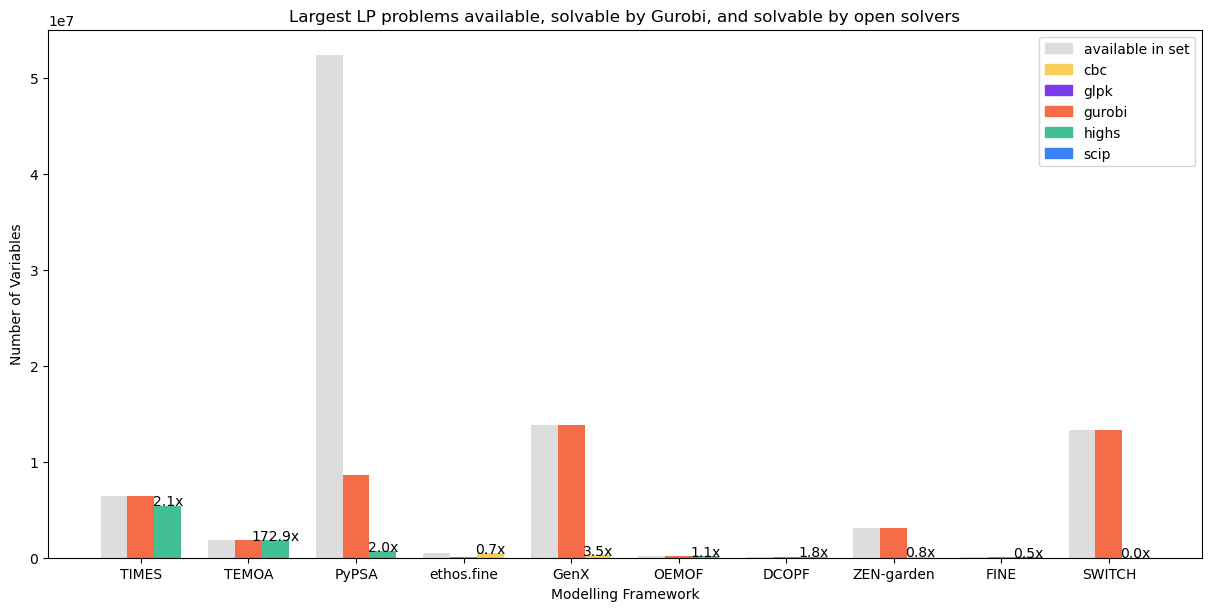

In [29]:
plot_largest_probs(largest_lp_per_model, "LP")

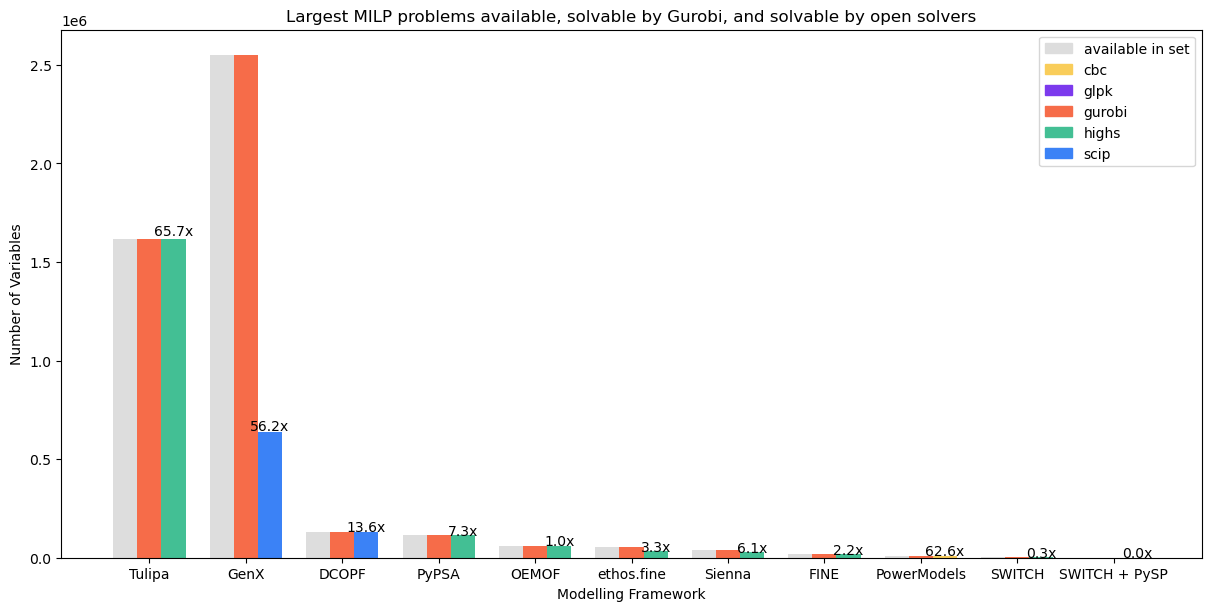

In [30]:
plot_largest_probs(largest_milp_per_model, "MILP")

## What factors affect solver performance?

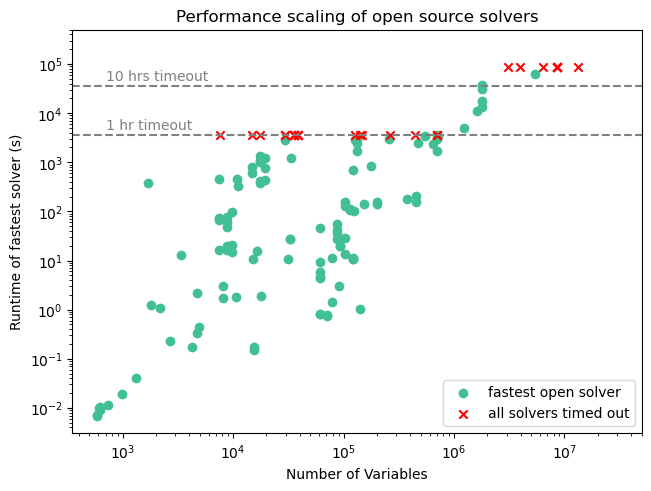

In [31]:
# Runtime vs number of variables for OS solvers and Gurobi
def plot_runtime_vs_num_vars(results, TO_results, title, color, label):
    fig, ax = plt.subplots(layout="constrained")
    # Add a dotted line at timeouts
    ax.axhline(60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 60 * 60 + 1000, "1 hr timeout", color="grey")
    ax.axhline(10 * 60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 10 * 60 * 60 + 10000, "10 hrs timeout", color="grey")
    ax.scatter(
        results["Num. Variables"],
        results["Runtime (s)"],
        c=color,
        label=label,
    )
    ax.scatter(
        TO_results["Num. Variables"],
        TO_results["Timeout"],
        c="red",
        marker="x",
        label="all solvers timed out",
    )
    ax.set_yscale("log")
    ax.set_ylim(None, 5e5)
    ax.set_xscale("log")
    ax.set_xlim(None, 5e7)
    ax.set_xlabel("Number of Variables")
    ax.set_ylabel("Runtime of fastest solver (s)")
    ax.set_title(title)
    ax.legend(loc="lower right")


os_statuses = (
    results_n_meta.query("Solver != 'gurobi'").groupby("bench-size")["Status"].unique()
)
os_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[os_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    os_feasible_results,
    os_TO_results,
    "Performance scaling of open source solvers",
    color_map["highs"],
    "fastest open solver",
)

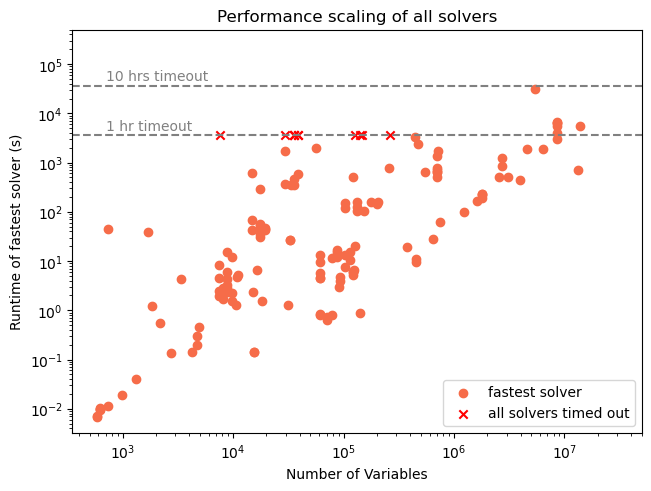

In [32]:
all_solver_results = (
    results_n_meta.query("Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)
all_statuses = results_n_meta.groupby("bench-size")["Status"].unique()
all_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[all_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    all_solver_results,
    all_TO_results,
    "Performance scaling of all solvers",
    color_map["gurobi"],
    "fastest solver",
)

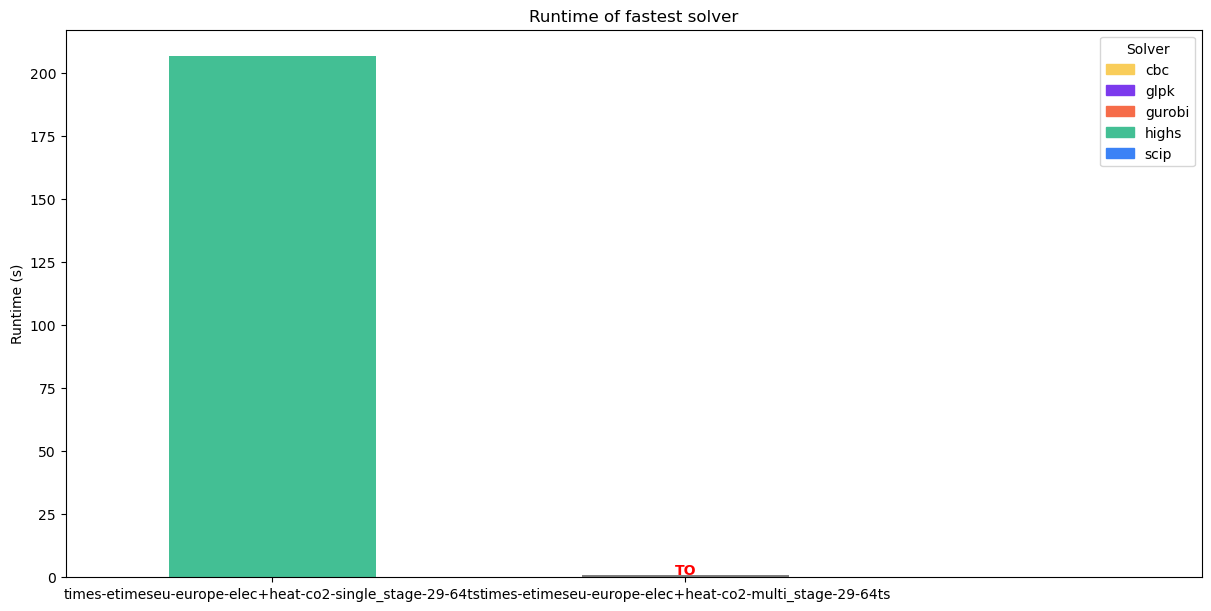

In [33]:
# Un-normalized runtime bar charts of the fastest (open) solver for a set of problems
def plot_fastest_runtime_of(to_plot, figsize=(8, 6), os_only=True):
    df = results[results["bench-size"].isin(set(to_plot))]

    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    if os_only:
        df_ok = df.query('Status == "ok" and Solver != "gurobi"')
    else:
        df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[
        df_ok.groupby("bench-size")["Runtime (s)"].idxmin()
    ].set_index("bench-size")

    width = 0.5

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    # Plot each benchmark
    for i, benchmark in enumerate(to_plot):
        if benchmark in fastest_runtimes.index:
            this_data = fastest_runtimes.loc[benchmark]
            colors = [color_map[this_data["Solver"]]]
            ax.bar([i], this_data["Runtime (s)"], width, color=colors)
        else:
            to_bar_height = 1
            ax.bar([i], to_bar_height, width, color=["grey"])
            ax.text(i, to_bar_height, "TO", ha="center", color="red", weight="bold")

    # Set x-ticks and labels
    xlabels = [f"{benchmark}" for benchmark in to_plot]
    ax.set_xticks(np.arange(len(to_plot)), xlabels)

    # Add labels and title
    ax.set_ylabel("Runtime (s)")
    ax.set_xlim(-0.5, len(to_plot) + 0.25)
    ax.set_title("Runtime of fastest solver")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


plot_fastest_runtime_of(
    # ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    # [
    #     "genx-elec_trex-15-168h",
    #     "genx-elec_trex_co2-15-168h",
    #     "genx-elec_trex_uc-15-24h",
    #     "genx-elec_co2-15-168h",
    # ],
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(12, 6),
)

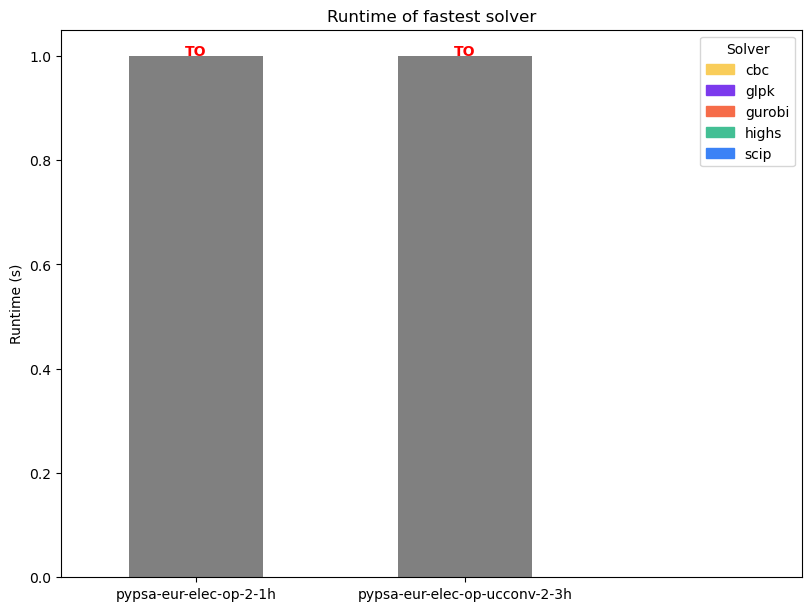

In [34]:
# The effect of unit commitment (MILP feature) on PyPSA
plot_fastest_runtime_of(
    ["pypsa-eur-elec-op-2-1h", "pypsa-eur-elec-op-ucconv-2-3h"],
    figsize=(8, 6),
    os_only=False,
)

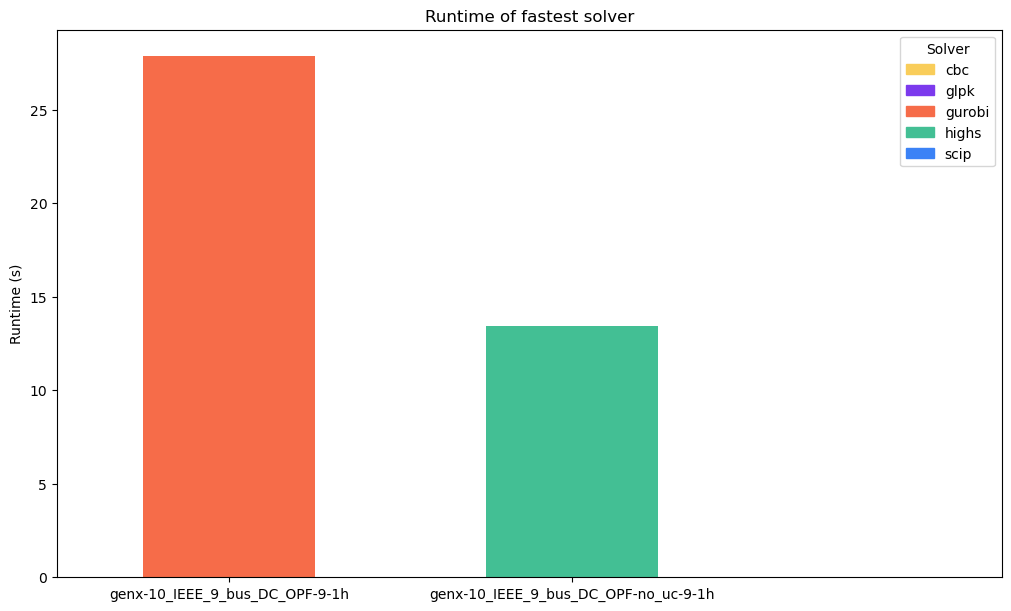

In [35]:
# The effect of unit commitment (MILP feature) on GenX
plot_fastest_runtime_of(
    ["genx-10_IEEE_9_bus_DC_OPF-9-1h", "genx-10_IEEE_9_bus_DC_OPF-no_uc-9-1h"],
    figsize=(10, 6),
    os_only=False,
)

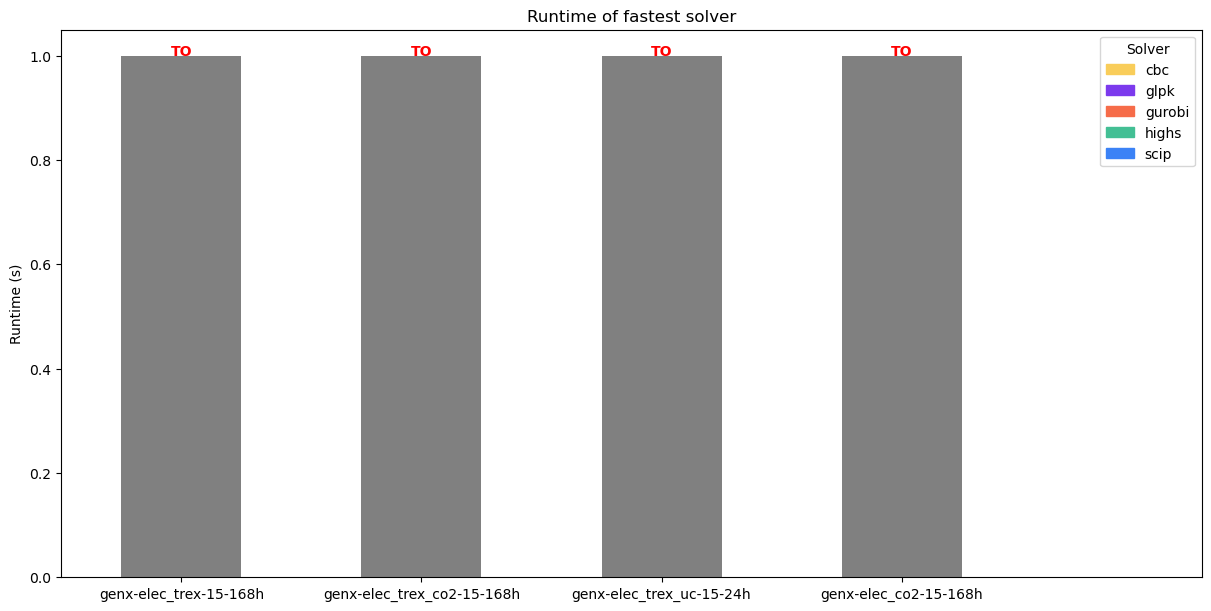

In [36]:
# The effect of UC, transmission expansion, and CO2 constraints in GenX
plot_fastest_runtime_of(
    [
        "genx-elec_trex-15-168h",
        "genx-elec_trex_co2-15-168h",
        "genx-elec_trex_uc-15-24h",
        "genx-elec_co2-15-168h",
    ],
    figsize=(12, 6),
    # os_only=False,
)

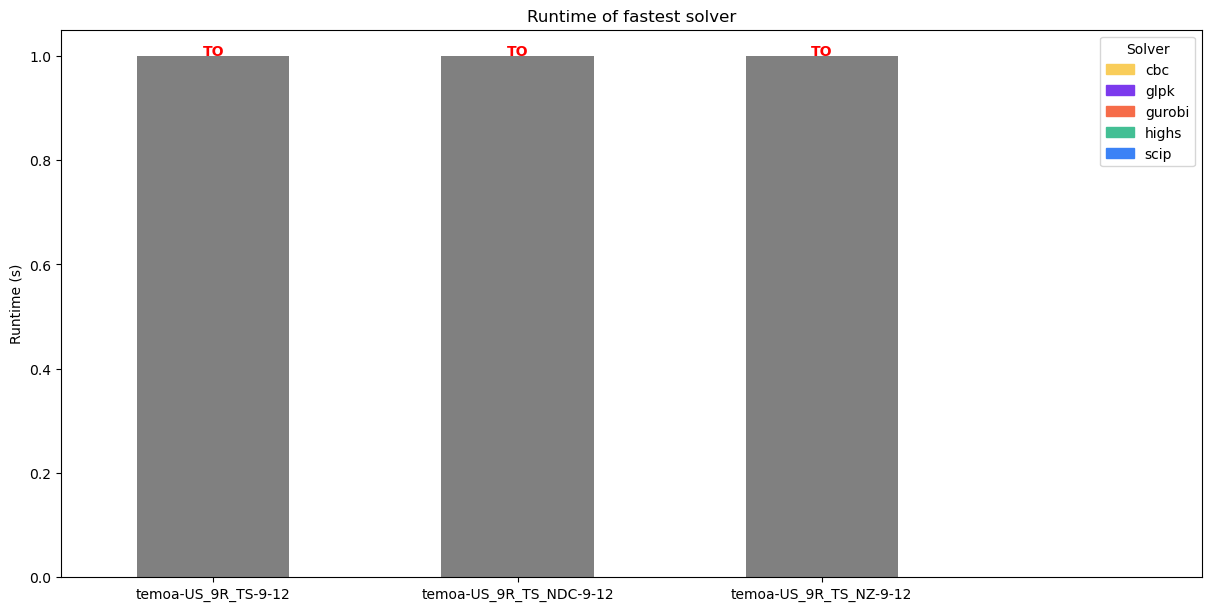

In [37]:
# The effect of CO2 constraints in TEMOA
plot_fastest_runtime_of(
    ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    figsize=(12, 6),
    os_only=False,
)

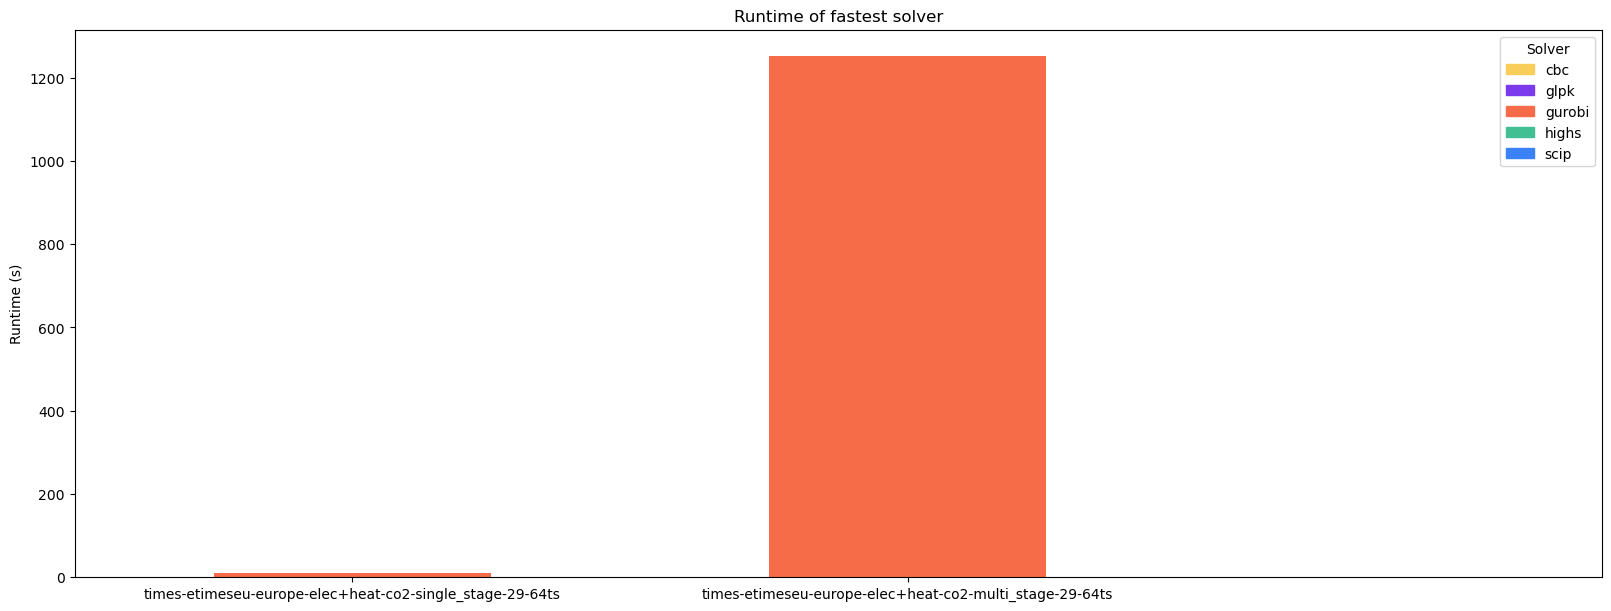

In [38]:
# The effect of time horizons in TIMES
plot_fastest_runtime_of(
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(16, 6),
    os_only=False,
)

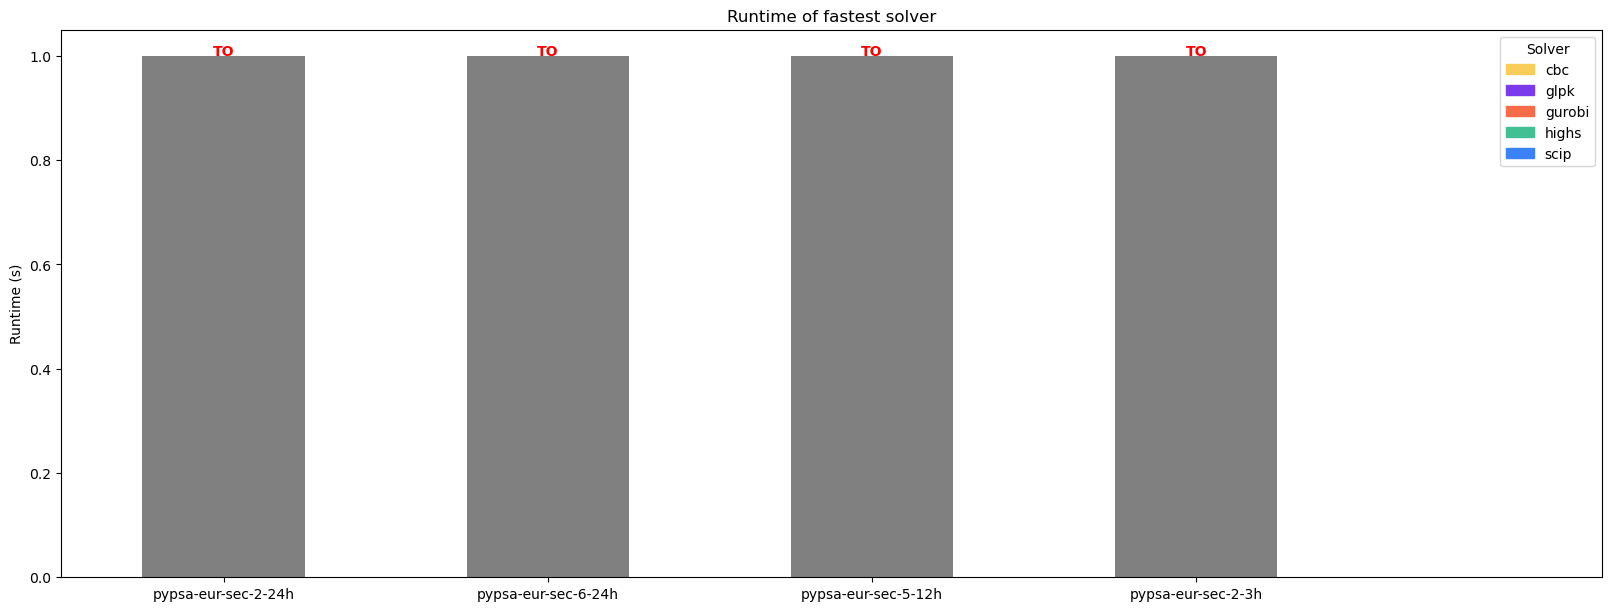

In [39]:
# Different size instances of pypsa models
plot_fastest_runtime_of(
    [
        "pypsa-eur-sec-2-24h",
        "pypsa-eur-sec-6-24h",
        "pypsa-eur-sec-5-12h",
        "pypsa-eur-sec-2-3h",
    ],
    figsize=(16, 6),
    os_only=False,
)